In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pdb, pickle, sys, itertools
from loguru import logger
from copy import deepcopy
import numpy as np
from numpy.random import choice as random_choice
from numpy.linalg import norm as euclidean_norm
from scipy.special import softmax
from scipy import integrate
from rtree import index

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import HTML, clear_output

import pybullet as pb
import pybullet_utils.bullet_client as bc
import pybullet_data as pbd

from utils.pb_sim_world_multicluster import PBSimWorld
from utils.robot_planner import RobotPlanner
from utils.robot_fsm import ManipulatorStateMachine, RobotStateMachine
from utils.robot_control import RobotControl
from utils.sensor_models import SensorModels

base_directory = './urdf_models/'
output_directory = './outputs/'

## init pybullet
pb_client = bc.BulletClient(connection_mode=pb.DIRECT)
pb_client.setAdditionalSearchPath(pbd.getDataPath())

## debug logger
logger.add("./msg_simulator.log")
logger.info("multi-robot trash collection simulation started")


2021-01-06 16:54:12.173 | INFO     | __main__:<module>:37 - multi-robot trash collection simulation started


### Rendering configuration

In [2]:
camTargetPos = [0, 0, 0]
cameraUp = [0, 0, 1]
cameraPos = [1, 1, 1]

camera_pitch = -90
camera_roll = 0
camera_yaw = 0

upAxisIndex = 2
camDistance = 1.0
pixelWidth = 320*8
pixelHeight = 200*8
nearPlane = 0.01
farPlane = 100

fov = 60

aspect = pixelWidth / pixelHeight

def img_processing(img_arr):
    """ convert pybullet image array to numpy array for displaying using imshow
    """
    
    w = img_arr[0]  #width of the image, in pixels
    h = img_arr[1]  #height of the image, in pixels
    rgb = img_arr[2]  #color data RGB
    dep = img_arr[3]  #depth data

    np_img_arr = np.reshape(rgb, (h, w, 4))
    np_img_arr = np_img_arr * (1. / 255.)
    
    return w,h,np_img_arr
    
def compute_view_matrix(camTargetPos, camDistance, camera_yaw, camera_pitch, camera_roll, upAxisIndex):
    view_matrix = pb.computeViewMatrixFromYawPitchRoll(camTargetPos, camDistance, camera_yaw, camera_pitch, camera_roll, upAxisIndex)
    
    return view_matrix
    
def compute_projection_matrix(fov, aspect, nearPlane, farPlane):
    projection_matrix = pb.computeProjectionMatrixFOV(fov, aspect, nearPlane, farPlane)

    return projection_matrix

def render_current_scene(cam_pitch=0, cam_roll=0, cam_yaw=0, cam_distance=1.0, cam_center=(0,0), figure_title=None, pdf_file=None):
    fig = plt.figure(figsize=(20, 14))
    ax = fig.add_subplot(1,1,1)

    img = [[1, 2, 3] * 50] * 100 
    image = ax.imshow(img, interpolation='none', animated=True, label="blah")

    upAxisIndex = 2
    pixelWidth = 320*8
    pixelHeight = 200*8
    nearPlane = 0.01
    farPlane = 100
    fov = 60
    
    view_matrix = compute_view_matrix(cam_center, cam_distance, cam_yaw, cam_pitch, cam_roll, upAxisIndex)
    projection_matrix = compute_projection_matrix(fov, aspect, nearPlane, farPlane)

    img_arr = pb_client.getCameraImage(pixelWidth,
                                       pixelHeight,
                                       view_matrix,
                                       projection_matrix,
                                       shadow=0,
                                       lightDirection=[-1, 1, 1],
                                       renderer=pb.ER_TINY_RENDERER)

    w,h,np_img_arr = img_processing(img_arr)
    image.set_data(np_img_arr) ## using set_data is faster

    if figure_title != None:
        ax.set_title(figure_title)
        
    plt.axis('off')
    plt.tight_layout()

    if pdf_file != None:
        plt.savefig(pdf_file, format='pdf')

    plt.show()

def render_landscape(figure_title=None, pdf_file=None):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)

    ## plot landscape
    N = 40000
    N_sqrt = int(np.sqrt(N))
    xedges = range(2*N_sqrt+1)
    yedges = range(2*N_sqrt+1)
    xedges_ds = xedges[::5]
    yedges_ds = yedges[::5]

    s_row = []
    s_column = []
    for cluster_index in range(number_of_clusters):
        data = centralized_robot_planner.get_clusters_belief_state()[cluster_index]["cells_belief_state"]

        for idx,val in enumerate(data):
            if val > 0:
                if cluster_index == 0:
                    s_column.append(int(idx/N_sqrt))
                    s_row.append(idx%N_sqrt)

                elif cluster_index == 1:
                    s_column.append(int(idx/N_sqrt))
                    s_row.append(idx%N_sqrt+N_sqrt)

                elif cluster_index == 2:
                    s_column.append(int(idx/N_sqrt)+N_sqrt)
                    s_row.append(idx%N_sqrt+N_sqrt)

                elif cluster_index == 3:
                    s_column.append(int(idx/N_sqrt)+N_sqrt)
                    s_row.append(idx%N_sqrt)

    H, xedges, yedges = np.histogram2d(s_row, s_column, bins=(xedges_ds,yedges_ds))

    ax.imshow(H, cmap = plt.cm.Reds, interpolation ='nearest', vmin=0, vmax=10) 
    
    ## plot robot trajectories
    for robot_id in traj_pose.keys():
        trajectories = traj_pose[robot_id][-100:]
        if (len(trajectories) == 0): continue

        x,y,_ = zip(*trajectories)
        x = (2*np.array(x)+40)
        y = (2*np.array(y)+40)
        
        plt.plot(x,y, color="black", linewidth=.5)
        plt.plot(x[-1], y[-1], 'bo', markersize=3)
        
    if figure_title != None:
        ax.set_title(figure_title)
        
    plt.axis('off')
    plt.tight_layout()
    
    if pdf_file != None:
        plt.savefig(pdf_file, format='pdf')
        
    plt.show()
#     plt.close()


In [3]:
def normalize_vector(v):
    return v/np.linalg.norm(v)

def consensus_model(x, t, b, p_1, p_2):
    a = 1
    
    x_1 = x[0]
    x_2 = x[1]
    
    x_dot = [-a*x_1 + b*(1/(1+np.exp(-x_2))-.5)+p_1,
             -a*x_2 + b*(1/(1+np.exp(-x_1))-.5)+p_2]
    
    return np.array(x_dot)

## Pitch-fork bifurcation consensus model to determine which direction to avoidance collision
def collision_avoidance_model(avoidance_direction, threshold_distance = 2.0):
    for robot1_id, robot2_id in itertools.combinations(robot_ids, 2):
        if fsm_robots[robot1_id].destination == None or fsm_robots[robot2_id].destination == None: continue
        
        robot1_destination = fsm_robots[robot1_id].destination
        robot1_pose, robot1_velocity = pb_robot_control.get_robot_state(robot_id=robot1_id)
        
        vector_to_robot1_destination = (robot1_destination[0]-robot1_pose[0], robot1_destination[1]-robot1_pose[1])
        unit_vector_to_robot1_destination = normalize_vector(vector_to_robot1_destination)
        unit_vector_robot1_yaw = np.array((np.cos(robot1_pose[2]), np.sin(robot1_pose[2])))
        
        robot2_destination = fsm_robots[robot2_id].destination
        robot2_pose, robot2_velocity = pb_robot_control.get_robot_state(robot_id=robot2_id)
        
        vector_to_robot2_destination = (robot2_destination[0]-robot2_pose[0], robot2_destination[1]-robot2_pose[1])
        unit_vector_to_robot2_destination = normalize_vector(vector_to_robot2_destination)
        unit_vector_robot2_yaw = np.array((np.cos(robot2_pose[2]), np.sin(robot2_pose[2])))

        vector_from_robot1_to_robot2 = np.array((robot2_pose[0]-robot1_pose[0], robot2_pose[1]-robot1_pose[1]))
        unit_vector_from_robot1_to_robot2 = normalize_vector(vector_from_robot1_to_robot2)
        correlation_coefficient_robot1 = np.dot(unit_vector_from_robot1_to_robot2, unit_vector_to_robot1_destination)
        correlation_coefficient_robot2 = np.dot(-unit_vector_from_robot1_to_robot2, unit_vector_to_robot2_destination)
        
        if (threshold_distance<euclidean_norm(vector_from_robot1_to_robot2) or 
            correlation_coefficient_robot1<=0 or 
            correlation_coefficient_robot2<=0 or 
            euclidean_norm(robot1_velocity)<.05 or 
            euclidean_norm(robot2_velocity)<.05):
            avoidance_direction[robot1_id][robot2_id] = 0
            avoidance_direction[robot2_id][robot1_id] = 0
            
        else:
            if avoidance_direction[robot1_id][robot2_id] == 0:
                
                ## initial condition for the consensus model
                x1_init = np.cross(unit_vector_from_robot1_to_robot2, unit_vector_robot1_yaw)
                x2_init = np.cross(-unit_vector_from_robot1_to_robot2, unit_vector_robot2_yaw)
                x_init = (x1_init, x2_init)

                b = np.exp(5*(threshold_distance - euclidean_norm(vector_from_robot1_to_robot2)))
                
                ## preference parameter for the consensus model
                p_1 = 1*np.cross(unit_vector_from_robot1_to_robot2, unit_vector_to_robot1_destination)
                p_2 = 1*np.cross(-unit_vector_from_robot1_to_robot2, unit_vector_to_robot2_destination)

                time_limit = 30
                dt = 1.0e-3
                time_span = np.linspace(0.0, time_limit-dt, int(time_limit/dt))
                x_trajectory = integrate.odeint(consensus_model, x_init, time_span, args=(b, p_1, p_2))
                decision_variable = x_trajectory[-1]

                if (decision_variable[0]*decision_variable[1] > 0 and 
                    euclidean_norm(decision_variable[0])>=.2 and 
                    euclidean_norm(decision_variable[1])>=.2):
                    avoidance_direction[robot1_id][robot2_id] = np.sign(decision_variable[0])
                    avoidance_direction[robot2_id][robot1_id] = np.sign(decision_variable[0])

                else:
                    avoidance_direction[robot1_id][robot2_id] = 0
                    avoidance_direction[robot2_id][robot1_id] = 0
                
    return avoidance_direction


In [4]:
def update_robot_state(robot_id):
    manipulator_state = pb_robot_control.get_manipulator_state(robot_id=robot_id)
    robot_state = pb_robot_control.get_robot_state(robot_id=robot_id)

    robot_cluster_index = fsm_robots[robot_id].cluster_index
    fsm_robots[robot_id].update_world_state(world_state[robot_cluster_index])
    fsm_robots[robot_id].run_once((manipulator_state, robot_state))
    
    return robot_cluster_index

def compute_robot_population_state():
    robot_population_state = {}
    for cluster_index in range(number_of_clusters):
        robot_population_state[cluster_index] = 0
        
    for robot_id in robot_ids:
        robot_cluster_index = fsm_robots[robot_id].cluster_index
        robot_population_state[robot_cluster_index] += 1
        
    return robot_population_state

def initialize_pybullet_simulator():
    robot_cluster_membership = pb_sim_world.initialize_simulator()
    for _ in range(1000): pb_client.stepSimulation()

    robot_ids = pb_sim_world.get_robot_ids()
    object_ids = pb_sim_world.get_object_ids()

    pb_sim_world.initialize_states()
    world_state = pb_sim_world.get_world_state()
    
    return robot_cluster_membership, robot_ids, object_ids, world_state

def initialize_simulation_variables():
    ## initialize object relocation timer
    object_relocation_times = {}
    for cluster_index in range(number_of_clusters):
        if (OBJECT_RELOCATION_RATE[cluster_index] > 0):    
            exponential_rv_samples = np.random.exponential(scale=1/OBJECT_RELOCATION_RATE[cluster_index], 
                                                           size=2*int(TOTAL_TIME_STEPS*dt*OBJECT_RELOCATION_RATE[cluster_index]))
            object_relocation_times[cluster_index] = list(np.cumsum(exponential_rv_samples))
            
        else:
            object_relocation_times[cluster_index] = []

    ## initialize the robot planner
    RobotPlanner.model_weight = 10.0
    RobotPlanner.revision_rate = 600.0
    
    centralized_robot_planner = RobotPlanner(number_of_robots=number_of_robots, 
                                             cluster_bounds=cluster_bounds, 
                                             robot_population_state_limit=[80]*number_of_clusters)
    for cluster_index in range(number_of_clusters):
        centralized_robot_planner.update_model_parameters(cluster_index=cluster_index,
                                                          model_parameters={"a": -.12, 
                                                                            "b": .9, 
                                                                            "object_relocation_rate": OBJECT_RELOCATION_RATE[cluster_index]})
    
    ## initialize the manipulator pose
    for robot_id in robot_ids:
        pb_robot_control.manipulator_origin(robot_id=robot_id)

    for _ in range(1000): pb_client.stepSimulation()

    ## initialize robot variables
    avoidance_direction = {}
    for robot1_id, robot2_id in itertools.product(robot_ids, repeat=2):
        if robot1_id not in avoidance_direction.keys():
            avoidance_direction[robot1_id] = {}

        avoidance_direction[robot1_id][robot2_id] = 0
        
    fsm_robots = {}
    poisson_clocks = {}
    for robot_id in robot_ids:
        robot_cluster_index = robot_cluster_membership[robot_id]
        fsm_robots[robot_id] = RobotStateMachine(pb_client, 
                                                 robot_id=robot_id, 
                                                 cluster_index=robot_cluster_index, 
                                                 max_linear_velocity=1*1.0,
                                                 max_rotational_velocity=2*np.pi)

        fsm_robots[robot_id].avoidance_direction = avoidance_direction

        if (CLUSTER_MEMBERSHIP_REVISION_RATE > 0):
            exponential_rv_samples = np.random.exponential(scale=1/CLUSTER_MEMBERSHIP_REVISION_RATE, 
                                                           size=2*int(TOTAL_TIME_STEPS*dt*CLUSTER_MEMBERSHIP_REVISION_RATE))
            poisson_clocks[robot_id] = list(np.cumsum(exponential_rv_samples))
            
        else:
            poisson_clocks[robot_id] = []

    return object_relocation_times, avoidance_direction, centralized_robot_planner, fsm_robots, poisson_clocks
        
def execute_simulation(time_instant):
    pb_sim_world.update_states()
    
    world_state = pb_sim_world.get_world_state()
    robot_population_state = compute_robot_population_state()
    centralized_robot_planner.update_clusters_belief_state(world_state, robot_population_state)
    
    ## record objects on the ground and relocate objects from the dumpster
    for cluster_index in range(number_of_clusters):
        objects_data = world_state[cluster_index]["objects"]
        objects_on_ground = [1 for object_id in objects_data.keys() if objects_data[object_id][1] == "ON_GROUND"]
        objects_count[cluster_index].append(np.sum(objects_on_ground))
            
        ## add objects to clusters
        if (len(object_relocation_times[cluster_index]) > 0 and object_relocation_times[cluster_index][0] <= time_instant):
            object_relocation_times[cluster_index].pop(0)
            pb_sim_world.relocate_object_from_dumpster(cluster_index)
    
    collision_avoidance_model(avoidance_direction, threshold_distance=1.0)
    for robot_id in robot_ids:
        robot_cluster_index = update_robot_state(robot_id)
    
        if (len(poisson_clocks[robot_id]) > 0 and poisson_clocks[robot_id][0] <= time_instant):
            poisson_clocks[robot_id].pop(0)
            new_robot_cluster_index = centralized_robot_planner.revise_cluster_membership(robot_cluster_index=robot_cluster_index)
#             new_robot_cluster_index = centralized_robot_planner.revise_cluster_membership_model_based(robot_cluster_index=robot_cluster_index)

            if new_robot_cluster_index != robot_cluster_index:
                robot_cluster_index = new_robot_cluster_index
                fsm_robots[robot_id].update_cluster_membership(robot_cluster_index, cluster_bounds[robot_cluster_index])

        fsm_robots[robot_id].avoidance_direction = avoidance_direction
        
        ## set a new destination (current implementation selects the location of the nearest object)
        if fsm_robots[robot_id].destination == None:
            new_destination = centralized_robot_planner.assign_destination(robot_cluster_index=robot_cluster_index)
            fsm_robots[robot_id].set_destination(new_destination)
            
            ## (when new destination is assigned) initialize avoidance_direction variable
            for robot2_id in avoidance_direction[robot_id].keys():
                avoidance_direction[robot_id][robot2_id] = 0

        pose, vel = pb_robot_control.get_robot_state(robot_id=robot_id)
        traj_pose[robot_id].append(pose)
        traj_vel[robot_id].append(vel)   
        cluster_membership[robot_id].append(robot_cluster_index)
    
    for _ in range(int(240/CONTROL_FREQUENCY)): pb_client.stepSimulation() # 240 Hz timestep
        

### Single shot processing with rendering

In [5]:
%%time

## simulation parameters
number_of_clusters = 1
cluster_bounds = [((-15, -15), (-5, -5))]

number_of_robots = [10]
number_of_objects = [200]
collection_sites = [((-20,0), 5)]

# cluster_bounds = [((-15, -15), (-5, -5)), 
#                   ((-15, 5), (-5, 15)),
#                   ((5, 5), (15, 15)), 
#                   ((5, -15), (15, -5))]
# number_of_clusters = len(cluster_bounds)

# number_of_robots = [10, 10, 10, 10]
# number_of_objects = [100, 200, 300, 400]
# collection_sites = [((-20,0), 5), ((20,0), 5), ((0,-20), 5), ((0,20), 5)]

CONTROL_FREQUENCY = 40 # robot control frequency
dt = 1/CONTROL_FREQUENCY

pb_sim_world = PBSimWorld(pb_client, 
                          number_of_robots=number_of_robots, 
                          number_of_objects=number_of_objects,
                          cluster_bounds=cluster_bounds,
                          collection_sites=collection_sites,
                          model_scale=1.0)

RobotStateMachine.collection_sites = collection_sites
pb_robot_control = RobotControl(pb_client)
pb_sensor_models = SensorModels(pb_client)


Wall time: 5.87 s


In [6]:
# TOTAL_TIME_STEPS = 30000
TOTAL_TIME_STEPS = 200

CLUSTER_MEMBERSHIP_REVISION_RATE = 0 # 1/seconds
OBJECT_RELOCATION_RATE = [0] # 1/seconds
# CLUSTER_MEMBERSHIP_REVISION_RATE = 1/8 # 1/seconds (Hz)
# OBJECT_RELOCATION_RATE = [1, 1/2, 1/3, 1/4] # 1/seconds (Hz)

## rendering configuration
# rendering = True
rendering = False

if rendering:
    pdf_file_number = 1
    pdf_file = PdfPages(output_directory + 'trash_collection_simulation_{:03d}.pdf'.format(pdf_file_number))
    
    pdf_file_landscape_number = 1
    pdf_file_landscape = PdfPages(output_directory + 'cluster_landscape_{:03d}.pdf'.format(pdf_file_landscape_number))

## initialize simulation
robot_cluster_membership, robot_ids, object_ids, world_state = initialize_pybullet_simulator()
object_relocation_times, avoidance_direction, centralized_robot_planner, fsm_robots, poisson_clocks = initialize_simulation_variables()

## initialize recording variables
traj_pose = {}
traj_vel = {}
cluster_membership = {}
for robot_id in robot_ids:    
    traj_pose[robot_id] = []
    traj_vel[robot_id] = []
    cluster_membership[robot_id] = []

objects_count = {}
for cluster_index in range(number_of_clusters):
    objects_count[cluster_index] = []
    
## main loop
for k in range(TOTAL_TIME_STEPS):
    time_instant = k*dt
    execute_simulation(time_instant)
    
    process_terminate_flag = True
    for cluster_index in range(number_of_clusters):
        if objects_count[cluster_index][-1]>0: 
            process_terminate_flag = False
            break
    
    if process_terminate_flag: break
        
    ## rendering current scene
    if rendering == False or k%8 != 0: continue    
        
#     if k%int(TOTAL_TIME_STEPS/15) != 0: continue
        
    ## rendering for robot object collect animation
    robot_id_to_render = 1
    pose, vel = pb_robot_control.get_robot_state(robot_id=robot_id_to_render)
    pos = (pose[0], pose[1], 0)
    cam_pitch=-10
    cam_roll=0
    cam_yaw=0
    cam_distance=2.0

    clear_output()
    render_current_scene(cam_pitch=cam_pitch, 
                         cam_roll=cam_roll, 
                         cam_yaw=cam_yaw, 
                         cam_distance=cam_distance, 
                         cam_center=pos,                              
                         figure_title="robot {} at {:.4f}".format(robot_id_to_render, time_instant),
                         pdf_file=pdf_file)
#                              pdf_file=None)

    render_landscape(pdf_file=pdf_file_landscape)
        
#     # plot each cluster
#     robot_population_state = compute_robot_population_state()
#     for cluster_index in range(number_of_clusters):
#         print("cluster {}:".format(cluster_index))
#         print("number of objects on ground: {}".format(objects_count[cluster_index][-1]))
#         print("number of robots assigned: {}".format(robot_population_state[cluster_index]))
        
#         cluster_center = np.mean(cluster_bounds[cluster_index], axis=0)
#         pos = (cluster_center[0], cluster_center[1], 0)
#         cam_pitch = -90
#         cam_roll = 0
#         cam_yaw = 0
#         cam_distance = 15.0
                
# #         clear_output()
#         render_current_scene(cam_pitch=cam_pitch, 
#                              cam_roll=cam_roll, 
#                              cam_yaw=cam_yaw, 
#                              cam_distance=cam_distance, 
#                              cam_center=pos,                              
#                              figure_title="cluster {} at {:.4f}".format(cluster_index, time_instant),
# #                              pdf_file=pdf_file)
#                              pdf_file=None)

#     ## plot object counts
#     fig = plt.figure(figsize=(15, 5))
#     ax = fig.add_subplot(1, 1, 1)

#     for cluster_index in range(number_of_clusters):
#         time_instants = np.linspace(0, time_instant, len(objects_count[cluster_index]))
#         ax.plot(time_instants, objects_count[cluster_index], linewidth=.8)

#     ax.set_xlabel('time (seconds)')
#     ax.set_ylabel('number of objects remaining')
#     ax.set_title('objects count')

#     plt.show()
    
    if pdf_file.get_pagecount() >= 200:
        pdf_file.close()
        
        pdf_file_number += 1
        pdf_file = PdfPages(output_directory + 'trash_collection_simulation_{:03d}.pdf'.format(pdf_file_number))
        
    if pdf_file_landscape.get_pagecount() >= 200:
        pdf_file_landscape.close()
        
        pdf_file_landscape_number += 1
        pdf_file_landscape = PdfPages(output_directory + 'cluster_landscape_{:03d}.pdf'.format(pdf_file_landscape_number))
        
if rendering:
    pdf_file.close()
    pdf_file_landscape.close()

### Plot result

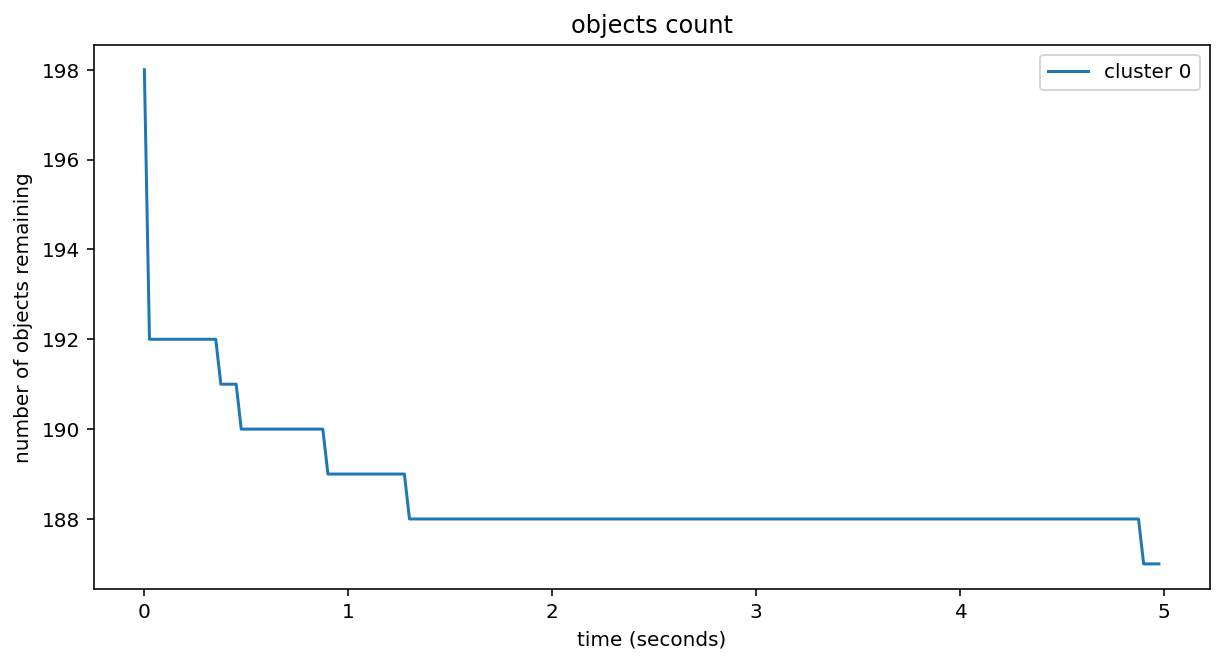

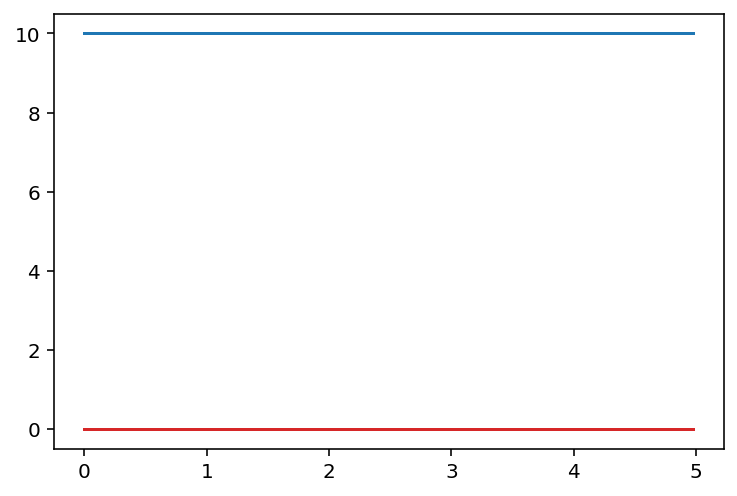

In [7]:
## plot object counts
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)

time_instant = k*dt
for cluster_index in range(number_of_clusters):
    time_instants = np.linspace(0, time_instant, len(objects_count[cluster_index]))
    ax.plot(time_instants, objects_count[cluster_index], label='cluster {}'.format(cluster_index))

    ax.set_xlabel('time (seconds)')
    ax.set_ylabel('number of objects remaining')
    ax.set_title('objects count')    
    ax.legend()

plt.show()

data_length = len(objects_count[cluster_index])
cluster_allocation = {}
for i in range(4):
    cluster_allocation[i] = np.zeros(data_length)
    
for robot_index in cluster_membership.keys():
    for time_index, cluster_index in enumerate(cluster_membership[robot_index]):
        cluster_allocation[cluster_index][time_index] += 1

for cluster_index in range(4):
    plt.plot(time_instants, cluster_allocation[cluster_index])
    
plt.show()


### Save simulation outcomes


In [8]:
output_data = {}

## simulation parameters
output_data["number_of_clusters"] = number_of_clusters
output_data["cluster_bounds"] = cluster_bounds
output_data["number_of_robots"] = number_of_robots
output_data["number_of_objects"] = number_of_objects
output_data["collection_sites"] = collection_sites

output_data["decision_noise_level"] = centralized_robot_planner.noise_level
output_data["cluster_membership_revision_rate"] = CLUSTER_MEMBERSHIP_REVISION_RATE
output_data["object_relocation_rate"] = OBJECT_RELOCATION_RATE

output_data["model_weight"] = RobotPlanner.model_weight
output_data["revision_rate"] = RobotPlanner.revision_rate

## simulation outcomes
output_data["pose_trajectories"] = traj_pose
output_data["velocity_trajectories"] = traj_vel
output_data["cluster_membership"] = cluster_membership
output_data["objects_count"] = objects_count
     
filename = output_directory+"pickle/multicluster_simulation/simulation_outcomes"

with open(filename, 'wb') as file_pickle:
    pickle.dump(output_data, file_pickle)
    

PermissionError: [Errno 13] Permission denied: './outputs/pickle/multicluster_simulation/simulation_outcomes'